**<p style="font-size:20px;">Bank Marketing Campaign Model</p>**

**Business Problem Understanding**

Bank X adalah salah satu bank yang menawarkan produk simpanan, pinjaman dan lain-lain kepada nasabah. saat ini bank X sedang membutuhkan analisa terhadap customer base-nya untuk membuat program marketing yang tepat sasaran.

**Problem Statement**

Program marketing yang tidak tepat sasaran dapat menimbulkan kerugian antara lain biaya pemasaran yang terbuang lebih besar, 
serta kerugian jangka panjang akibat tidak mampunya bank untuk mengakuisisi nasabah yang tepat sasaran.

**Goals**

Tujuan dari analisis dan modeling ini adalah untuk mengetahui profil nasabah yang memiliki kemungkinan lebih tinggi untuk menempatkan dananya di bank (deposit). Dengan adanya analisis modeling yang akurat, bank dapat mengalokasikan anggaran promosi dengan lebih efisien untuk menyasar nasabah yang memiliki profil dengan kemungkinan tertinggi untuk menempatkan dana.

**Analytic Approach:**

Untuk melakukan hal tersebut, kita akan mencoba untuk membangun sebuah model untuk memprediksi nasabah yang cendrung tertarik untuk menempatkan dana.
Metode yang dilakukan adalah supervised learning karena datanya sudah memiliki label, dalam hal ini adalah penempatan dana.

Adapun metode supervised learning yang digunakan adalah jenis klasifikasi yang akan membantu perusahaan untuk dapat menganalisis efektivitas program pemasaran sebelumnya dengan memeriksa hal-hal antara lain:
- jumlah / berapa kali nasabah dihubungi
- waktu kontak terakhir dilakukan
- hasil program sebelumnya
- respon calon nasabah.


**Metric Evaluation**

Sasaran analisis adalah sebagai berikut: 

0: Tidak (Tidak berkenan untuk menempatkan dana) 

1: Ya (bermaksud untuk membuka rekening dana)

**Type I Error | False Positive** : ketika sistem memprediksi minat nasabah untuk menempatkan dana, namun pada kenyataannya, mereka tidak bermaksud melakukannya, hal tersebut berarti program pemasaran sia-sia karena nasabah tersebut memiliki kecenderungan untuk tidak menempatkan dana.

**Type II Error | False Negative** : ketika sistem memprediksi bahwa nasabah tidak tertarik untuk menempatkan dana, namun pada kenyataannya, mereka ingin menempatkan dana, hasilnya adalah bahwa bank akan kehilangan potensi keuntungan dari nasabah tersebut.

**<p style="font-size:20px;">Data Understanding</p>**

**customer profile**

age : umur nasabah

job : pekerjaan nasabah

balance : saldo nasabah

housing : nasabah yang memiliki kredit KPR (yes/no)

loan : nasabah yang memiliki kredit jenis lain di bank (yes/no)

**Marketing data**

contact: tipe komunikasi (telepon, cellular(handphone))

month: bulan terakhir nasabah tersebut dihubungi

campaign: jumlah call yang dilakukan terhadap nasabah tersebut selama periode program sebelumnya

pdays: jumlah hari setelah nasabah dihubungi pada program sebelumnya

poutcome: hasil dari program sebelumnya.

deposit: apakah nasabah tersebut akhirnya melakukan pembukaan rekening dan menempatkan dananya (yes/no)

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score


# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
bank_dataset = pd.read_csv("data_bank_marketing_campaign.csv")
bank_dataset

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [3]:
#info data

bank_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


<Axes: >

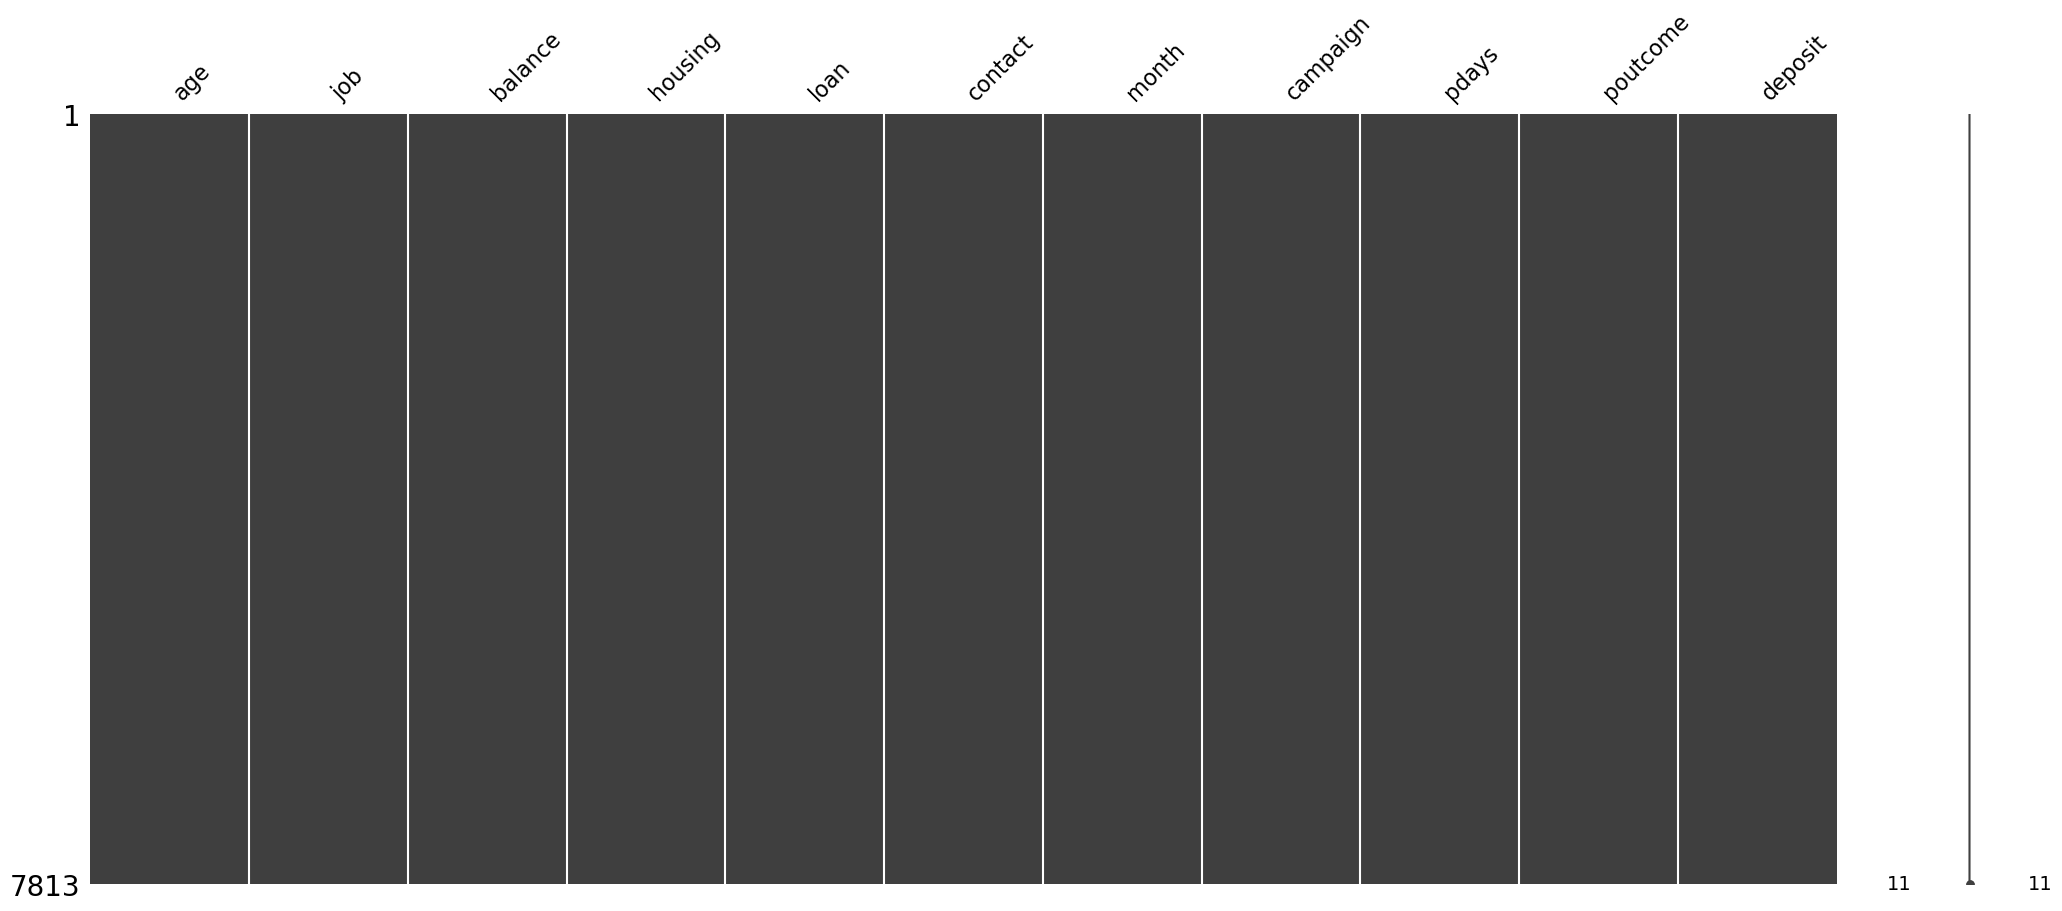

In [4]:
#cek null dengan missingno
missingno.matrix(bank_dataset)

Tidak ada null, namun terdapat beberapa data dengan kategori "unknown" yang tampil pada kilasan data ini. sekarang akan kita coba untuk melihatnya.

In [5]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in bank_dataset.columns :
    listItem.append( [col, bank_dataset[col].nunique(), bank_dataset[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[no, yes]"
4,loan,2,"[no, yes]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


Terdapat nilai "unknown" pada kolom job, contact, dan poutcome.

In [6]:
bank_dataset['contact'].value_counts()

contact
cellular     5628
unknown      1639
telephone     546
Name: count, dtype: int64

In [7]:
bank_dataset['poutcome'].value_counts()

poutcome
unknown    5819
failure     848
success     761
other       385
Name: count, dtype: int64

In [8]:
bank_dataset['job'].value_counts()

job
management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: count, dtype: int64

Pada data ini saya akan coba melakukan beberapa judgement untuk penanganannya.

1. Untuk data unknown pada pekerjaan, jumlahnya tidak signifikan dan bisa jadi dikarenakan nasabah tersebut memiliki pekerjaan lain yang tidak terdapat pada kriteria yang ditetapkan, sehingga tidak akan diproses lebih lanjut.

2. Untuk data unknown pada kontak, jumlahnya cukup banyak yaitu 1.639 dari 7.813 baris. Mengingat 2 kategori sisanya adalah "telephone" dan "cellular" yang sebenarnya memiliki kesamaan (hubungi nasabah melalui telepon genggam / telepon rumah), maka saya rasa tidak terlalu diproses lebih lanjut, karena informasi ini mungkin tidak akan terlalu berpengaruh pada hasil program.

3. Jumlah unknown pada poutcome terlalu banyak, namun sepertinya bisa dibandingkan dengan kolom "deposit" yang secara jelas menunjukkan bahwa nasabah membuka rekening atau tidak. selanjutnya akan saya cek menggunakan pivot table.

In [9]:
# Membuat pivot table
pivot_table = pd.pivot_table(bank_dataset, 
                             index='poutcome', 
                             columns='deposit', 
                             aggfunc='size', 
                             fill_value=0)

print(pivot_table)

deposit     no   yes
poutcome            
failure    413   435
other      159   226
success     65   696
unknown   3444  2375


dengan menggunakan pivot table tersebut terlihat bahwa tidak ada indikasi hubungan antara unknown dan other terhadap deposito yang dibuat, karena baik other maupun unknown memiliki beberapa nilai di "no" dan "yes". 

bahkan apabila kita mengacu pada kolom tersebut, ada nasabah yang secara kategori masuk ke dalam "sukses" di program pemasaran sebelumnya, namun terbukti tidak melakukan penempatan dana di bank. (poutcome = success & deposit = no)

sebaliknya ada juga nasabah yang secara kategori masuk ke dalam "gagal" di program pemasaran sebelumnya, namun justru melakukan penempatan dana di bank. (poutcome = failure & deposit = yes)

karena hasil yang tidak konsisten ini, maka kolom poutcome akan kami drop. keberhasilan program akan dilihat dari kolom "deposit".

In [10]:
bank_model = bank_dataset.copy()
bank_model.drop(columns=['poutcome'], inplace=True)

In [11]:
bank_model

,age,job,balance,housing,loan,contact,month,campaign,pdays,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,yes
2,51,admin.,3025,no,no,cellular,may,1,352,yes
3,38,services,-87,yes,no,cellular,may,1,-1,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,no
...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,no


Selanjutnya kita akan melakukan cek outlier numerikal. variabel yang dicek adalah:

Age = umur nasabah, apakah terdapat angka yang tidak masuk akal
Saldo = saldo nasabah
Pdays = jumlah hari yang berlalu setelah nasabah dihubungi pada program sebelumnya
Campaign = berapa kali nasabah dihubungi pada program sebelumnya

Text(0.5, 1.0, 'balance')

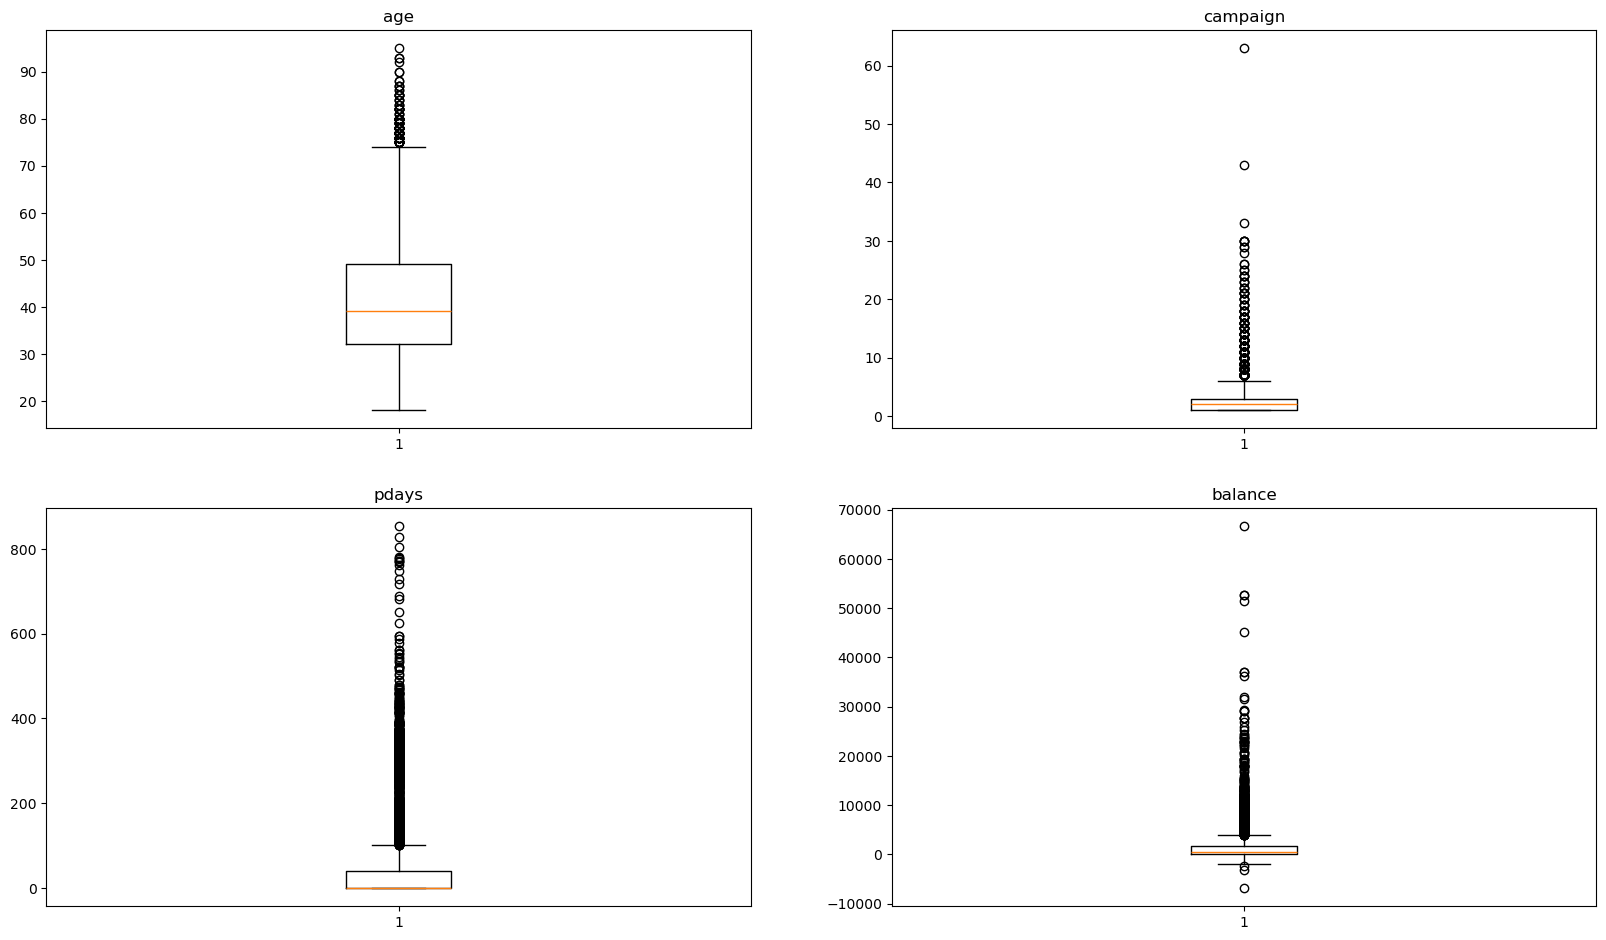

In [12]:
plt.figure(figsize = (20, 30))
ax=plt.subplot(521)
plt.boxplot(bank_model['age'])
ax.set_title('age')
ax=plt.subplot(522)
plt.boxplot(bank_model['campaign'])
ax.set_title('campaign')
ax=plt.subplot(523)
plt.boxplot(bank_model['pdays'])
ax.set_title('pdays')
ax=plt.subplot(524)
plt.boxplot(bank_model['balance'])
ax.set_title('balance')

Pada beberapa kasus, sebenarnya hal ini masih relatif mungkin terjadi, misalkan :

Age : sangat wajar terdapat beberapa nasabah yang usianya sudah lanjut dan masih dapat dihubungi.

Balance : sangat wajar terdapat nasabah-nasabah dengan saldo tinggi yang tentu saja akan terlihat sebagai outlier dibandingkan nasabah dengan jumlah tabungan lebih kecil. (jumlah nasabah prioritas lebih sedikit daripada nasabah umum)

pdays : sangat wajar nasabah yang pernah dihubungi pada suatu program (beberapa bulan bahkan 1-3 tahun sejak terakhir dihubungi), namun karena tidak memberikan respon positif maka tidak dihubungi lagi untuk program berikutnya.

campaign (jumlah nasabah dihubungi) : sangat wajar terdapat nasabah yang tidak mengangkat telepon sehingga petugas menghubungi nasabah tersebut berkali-kali sampai menjawab. hal ini merupakan praktek yang umum di industri keuangan seperti perbankan atau asuransi.

**sehubungan dengan hal tersebut, maka kita tidak akan melakukan drop data berdasarkan outlier.**

**<p style="font-size:20px;">Data Analysis</p>**

Sebagaimana dijelaskan sebelumnya, kita akan menggunakan parameter "deposit" sebagai tolak ukur kesuksesan (yes & no). kita ubah menjadi numerik.

In [13]:
# Nilai Pengganti
replace_values = {"yes": 1, "no": 0}

# Ganti nilai kolom "deposit" menggunakan metode replace
bank_model['deposit'].replace(replace_values, inplace=True)

bank_model.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,1
2,51,admin.,3025,no,no,cellular,may,1,352,1
3,38,services,-87,yes,no,cellular,may,1,-1,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,0


Selanjutnya kita akan mengklasifikasikan categorical features, dan mengecek isi kategori tersebut.

In [14]:
categories=[feature for feature in bank_model.columns if ((bank_model[feature].dtypes=='O') & (feature not in ['deposit']))]
categories

['job', 'housing', 'loan', 'contact', 'month']

In [15]:
for feature in categories:
    print('Fitur {} memiliki isi sebanyak {}'.format(feature,len(bank_model[feature].unique())))

Fitur job memiliki isi sebanyak 12
Fitur housing memiliki isi sebanyak 2
Fitur loan memiliki isi sebanyak 2
Fitur contact memiliki isi sebanyak 3
Fitur month memiliki isi sebanyak 12


Membuat infografis sederhana berdasarkan kategori yang telah disiapkan :

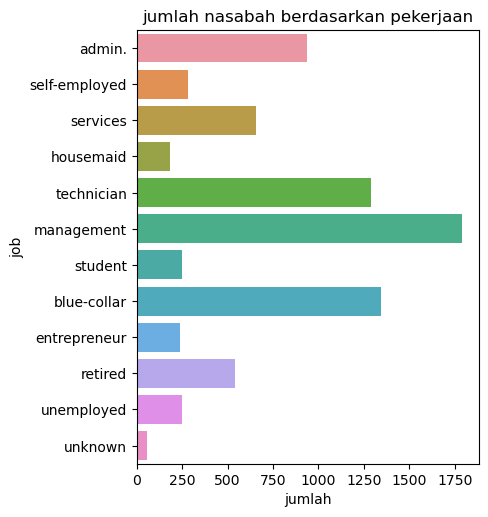

In [16]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
ax = plt.subplot(12,3,plotnumber)
sns.countplot(y='job',data=bank_model)
plt.xlabel('jumlah')
plt.title('jumlah nasabah berdasarkan pekerjaan')
plt.show()

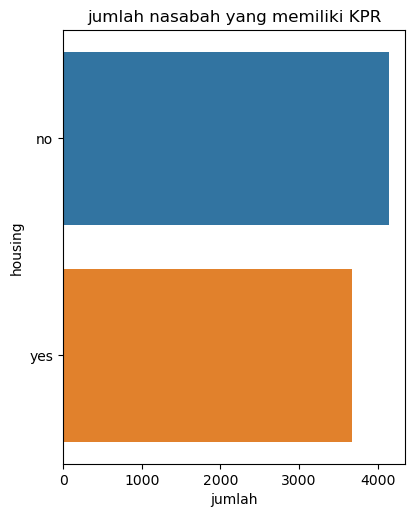

In [17]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
ax = plt.subplot(12,3,plotnumber)
sns.countplot(y='housing',data=bank_model)
plt.xlabel('jumlah')
plt.title('jumlah nasabah yang memiliki KPR')
plt.show()

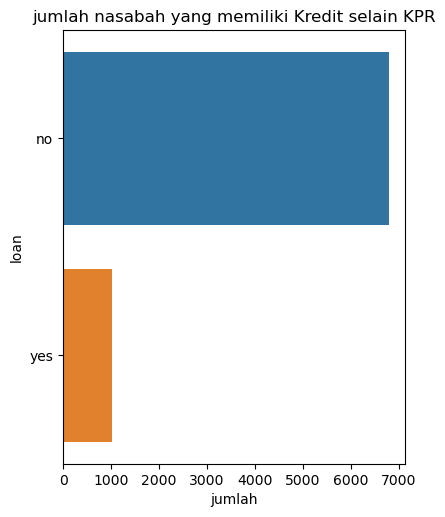

In [18]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
ax = plt.subplot(12,3,plotnumber)
sns.countplot(y='loan',data=bank_model)
plt.xlabel('jumlah')
plt.title('jumlah nasabah yang memiliki Kredit selain KPR')
plt.show()

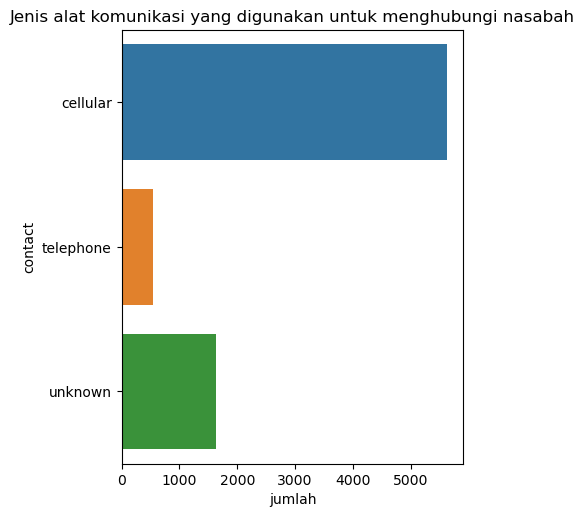

In [19]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
ax = plt.subplot(12,3,plotnumber)
sns.countplot(y='contact',data=bank_model)
plt.xlabel('jumlah')
plt.title('Jenis alat komunikasi yang digunakan untuk menghubungi nasabah')
plt.show()

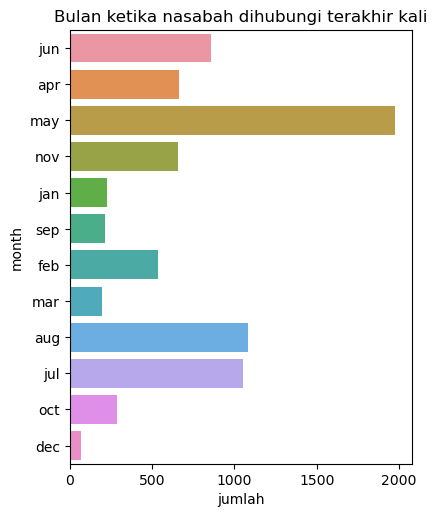

In [20]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
ax = plt.subplot(12,3,plotnumber)
sns.countplot(y='month',data=bank_model)
plt.xlabel('jumlah')
plt.title('Bulan ketika nasabah dihubungi terakhir kali')
plt.show()

Selanjutnya kita akan mengetahui profil nasabah yang melakukan penempatan dana di bank, dalam hal ini memiliki nilai "1" pada "Deposit".

In [21]:
Nasabah_Dana = bank_model[bank_model['deposit'] >= 1]
Nasabah_Dana

,age,job,balance,housing,loan,contact,month,campaign,pdays,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,1
2,51,admin.,3025,no,no,cellular,may,1,352,1
6,37,admin.,4803,no,no,cellular,jan,2,-1,1
7,36,technician,911,yes,yes,cellular,may,2,21,1
...,...,...,...,...,...,...,...,...,...,...
7802,63,retired,12067,no,no,telephone,apr,1,191,1
7805,47,management,159,no,no,telephone,oct,3,155,1
7808,62,housemaid,2,no,no,cellular,nov,1,-1,1
7809,48,housemaid,5473,no,no,cellular,feb,2,184,1


Profil pertama adalah nasabah berdasarkan jenis pekerjaan.

In [22]:
# Membuat pivot table
pivot_job = pd.pivot_table(Nasabah_Dana, 
                             index='job', 
                             values='balance', 
                             aggfunc={'job': 'count', 'balance': ['mean', 'sum']},
                             fill_value=0)

pivot_job.columns = ['Rata-Rata Saldo', 'Total Saldo', 'Jumlah Nasabah']
pivot_job = pivot_job.reset_index()

pivot_job

,job,Rata-Rata Saldo,Total Saldo,Jumlah Nasabah
0,admin.,1457.421171,647095,444
1,blue-collar,1299.323413,654859,504
2,entrepreneur,2077.882979,195321,94
3,housemaid,1987.430556,143095,72
4,management,2195.292123,2006497,914
5,retired,2314.616438,844835,365
6,self-employed,2638.881890,335138,127
7,services,1156.434615,300673,260
8,student,1501.119565,276206,184
9,technician,1824.410084,1085524,595


Jenis nasabah yang paling banyak menempatkan dana adalah nasabah dengan pekerjaan sebagai **manajemen perusahaan, teknisi, blue-collar, dan admin**. namun dari sisi rata-rata saldo, nasabah dengan profesi self-employed (pengusaha), retired (pensiunan), manajemen perusahaan dan enterpreneur memiliki rata-rata saldo yang relatif tinggi.

Untuk kategori usia, kita dapat memberikan kelompok pada nasabah berdasarkan usia.

In [23]:
# Tentukan rentang nilai untuk setiap kelompok
range_usia = [0, 9, 17, 59, float('inf')]

# Tentukan label untuk setiap kelompok
usia = ['Anak-anak', 'Remaja', 'Dewasa', 'Lansia']

# Lakukan binning menggunakan pd.cut
kelompok_usia = pd.cut(bank_model.age, bins=range_usia, labels=usia, right=False)

kelompok_usia

0       Dewasa
1       Dewasa
2       Dewasa
3       Dewasa
4       Dewasa
         ...  
7808    Lansia
7809    Dewasa
7810    Dewasa
7811    Dewasa
7812    Lansia
Name: age, Length: 7813, dtype: category
Categories (4, object): ['Anak-anak' < 'Remaja' < 'Dewasa' < 'Lansia']

In [24]:
# Gabungkan balance_bins dengan data awal
bank_model = bank_model.assign(kelompok_usia=kelompok_usia)
Nasabah_Dana = Nasabah_Dana.assign(kelompok_usia=kelompok_usia)

In [25]:
Nasabah_Dana

,age,job,balance,housing,loan,contact,month,campaign,pdays,deposit,kelompok_usia
0,55,admin.,1662,no,no,cellular,jun,2,-1,1,Dewasa
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,1,Dewasa
2,51,admin.,3025,no,no,cellular,may,1,352,1,Dewasa
6,37,admin.,4803,no,no,cellular,jan,2,-1,1,Dewasa
7,36,technician,911,yes,yes,cellular,may,2,21,1,Dewasa
...,...,...,...,...,...,...,...,...,...,...,...
7802,63,retired,12067,no,no,telephone,apr,1,191,1,Lansia
7805,47,management,159,no,no,telephone,oct,3,155,1,Dewasa
7808,62,housemaid,2,no,no,cellular,nov,1,-1,1,Lansia
7809,48,housemaid,5473,no,no,cellular,feb,2,184,1,Dewasa


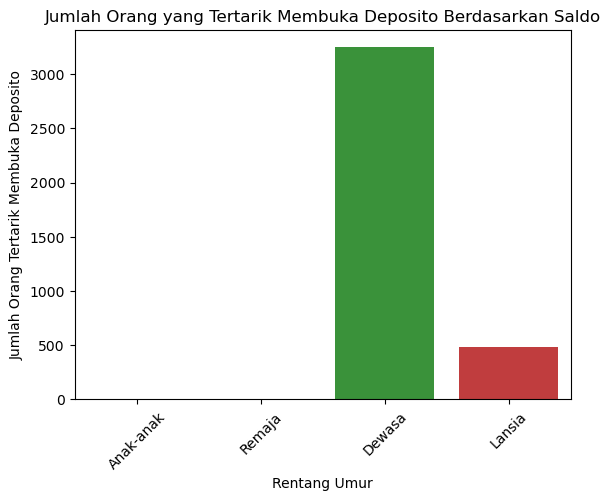

In [26]:
# Hitung jumlah deposit untuk setiap rentang saldo
Nasabah_Dana_Umur = Nasabah_Dana.groupby('kelompok_usia').size().reset_index(name='jumlah')

# Visualisasi menggunakan Seaborn
sns.barplot(x='kelompok_usia', y='jumlah', data=Nasabah_Dana_Umur)
plt.title('Jumlah Orang yang Tertarik Membuka Deposito Berdasarkan Saldo')
plt.xlabel('Rentang Umur')
plt.ylabel('Jumlah Orang Tertarik Membuka Deposito')
plt.xticks(rotation=45)
plt.show()

Hal ini memperlihatkan bahwa nasabah yang cenderung menempatkan dana adalah nasabah di usia dewasa. (17-59 tahun)

Selanjutnya kita akan melakukan model training.

In [27]:
# Pisahkan fitur dan target
X = bank_model.drop('deposit', axis=1)
y = bank_model['deposit']

In [33]:
# Membagi data menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

Test size 0.2: Artinya, 20% dari data digunakan untuk pengujian (testing), sementara 80% digunakan untuk pelatihan (training).

In [34]:
# Identifikasi fitur kategorikal dan numerik
categorical_features = ['job', 'housing', 'loan', 'contact', 'month']
numerical_features = ['age', 'balance', 'campaign', 'pdays']

In [35]:
# Buat preprocess pipeline untuk fitur kategorikal dan numerik
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [36]:
# Buat pipeline dengan preprocessor dan model RandomForest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=2024))
])

In [37]:
# Train model
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

In [38]:
# Evaluasi
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[626 192]
 [280 465]]


In [40]:
# Hitung Type I Error dan Type II Error
type_i_error = fp / (fp + tn)
type_ii_error = fn / (fn + tp)

print("Type I Error (False Positive Rate):", type_i_error)
print("Type II Error (False Negative Rate):", type_ii_error)

Type I Error (False Positive Rate): 0.23471882640586797
Type II Error (False Negative Rate): 0.37583892617449666


Tingginya Type II Error (false negatives) berarti bank mungkin kehilangan peluang dari nasabah yang sebenarnya tertarik menempatkan dana. Di sisi lain, Type I Error (false positives) berarti ada beberapa usaha pemasaran yang sia-sia untuk nasabah yang tidak berminat.

In [46]:
# Print classification report untuk metrik lainnya
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6980166346769033
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       818
           1       0.71      0.62      0.66       745

    accuracy                           0.70      1563
   macro avg       0.70      0.69      0.69      1563
weighted avg       0.70      0.70      0.70      1563



In [47]:
# Simpan model
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

**Accuracy**

**Accuracy**: 0.698: Akurasi mengukur persentase prediksi yang benar dari keseluruhan prediksi. Dalam kasus ini, model memiliki akurasi sekitar 70%, yang berarti **model berhasil memprediksi dengan benar** sekitar 70% dari semua contoh yang diuji.

**Precision, Recall, dan F1-Score**
Precision, recall, dan F1-score adalah metrik yang memberikan gambaran lebih rinci tentang kinerja model, terutama pada masing-masing kelas. Berikut interpretasi untuk masing-masing kelas (0 dan 1):

**Kelas 0 (Tidak Menempatkan Dana)**

-------------------------------------

**Precision:** 0.69: Dari semua prediksi yang menyatakan nasabah tidak akan menempatkan dana (kelas 0), 69% di antaranya benar.

**Recall:** 0.77: Dari semua nasabah yang sebenarnya tidak menempatkan dana, model berhasil mengidentifikasi 77% dengan benar.

**F1-Score:** 0.73: F1-Score adalah rata-rata harmonis dari precision dan recall. Skor ini menunjukkan keseimbangan antara precision dan recall untuk kelas 0.

**Kelas 1 (Menempatkan Dana)**

-------------------------------

**Precision:** 0.71: Dari semua prediksi yang menyatakan nasabah akan menempatkan dana (kelas 1), 71% di antaranya benar.

**Recall:** 0.62: Dari semua nasabah yang sebenarnya menempatkan dana, model berhasil mengidentifikasi 62% dengan benar.

**F1-Score:** 0.66: F1-Score adalah rata-rata harmonis dari precision dan recall. Skor ini menunjukkan keseimbangan antara precision dan recall untuk kelas 1.

Macro Average dan Weighted Average
Macro Average: Rata-rata precision, recall, dan F1-score dihitung untuk setiap kelas dan kemudian dirata-rata. Ini memperlakukan setiap kelas dengan bobot yang sama.

Weighted Average: Rata-rata precision, recall, dan F1-score dihitung dengan mempertimbangkan jumlah sampel di setiap kelas. Ini memberikan bobot lebih pada kelas dengan lebih banyak sampel.

**Kesimpulan**
==============

**Precision dan Recall**: Precision untuk kelas 1 (71%) lebih tinggi daripada recall untuk kelas 1 (62%), yang menunjukkan bahwa model lebih baik dalam memprediksi bahwa nasabah akan menempatkan dana, tetapi sering kali melewatkan nasabah yang sebenarnya bermaksud menempatkan dana (Type II Error lebih tinggi).

**F1-Score**: F1-score untuk kedua kelas cukup seimbang, menunjukkan bahwa model memiliki kinerja yang cukup baik secara keseluruhan, meskipun ada ruang untuk perbaikan.

**Accuracy:** Akurasi 70% menunjukkan kinerja yang cukup baik, tetapi model masih bisa ditingkatkan terutama untuk meningkatkan recall pada kelas 1.

**Type I Error dan Type II Error:** Tingginya Type II Error (false negatives) berarti bank mungkin kehilangan peluang dari nasabah yang sebenarnya tertarik menempatkan dana. Di sisi lain, Type I Error (false positives) berarti ada beberapa usaha pemasaran yang sia-sia untuk nasabah yang tidak berminat.


**Contoh Simulasi**
====

Misalkan Bank memiliki target nama 1000 orang yang telah diproses menggunakan model ini, dan 1 nama diasumsikan memakan biaya Rp10.000 untuk menghubunginya (biaya pulsa). Model memiliki Type I error sebesar 23%. Maka jumlah biaya yang mungkin terbuang adalah:

23% x 1.000 (nasabah) x 10.000 (rupiah) = 2.300.000

Sedangkan apabila bank salah memilih nama nasabah yang seharusnya dapat melakukan pembukaan rekening namun tidak dihubungi, kerugiannya adalah sebagai berikut, dengan asumsi keuntungan yang diterima (misal dari biaya rekening bulanan sebesar 15.000 tiap nasabah selama 1 bulan)
Model memiliki Type II error sebesar 37%, maka jumlah keuntungan yang mungkin tidak jadi didapatkan adalah:

Potensi Pendapatan = 37% x 1000 (nasabah) x 15000 (rupiah) x 12 (bulan) = 66.600.000
Biaya pemasaran = 37% x 1000 (nasabah) x 10000 (rupiah) = 3.700.000
Potensi Pendapatan yang tidak jadi didapat = 62.900.000


**Keterbatasan dan Rekomendasi**
=======

Dari sisi data:

Data ini memiliki beberapa data outlier, yang walaupun masih masuk akal, dapat membuat hasil kurang akurat. (misal ada beberapa nasabah yang memiliki saldo tinggi) saran untuk penelitian selanjutnya, mungkin dapat dibedakan berdasarkan kelas penghasilan nasabah apabila terdapat datanya. 
selain itu data ini juga hanya memuat data nasabah pada 1 tahun saja karena tidak terdapat info tahun data.

Dari sisi metode:

saya tidak melakukan improvement akurasi model karena keterbatasan waktu, mungkin akan lebih baik jika penelitian berikutnya dapat menggunakan metode-metode yang dapat meningkatkan kemampuan evaluasi model seperti hyperparameter tuning atau model lain seperti Logistic Regression, Support Vector Machine (SVM), Gradient Boosting Machines (GBM), XGBoost, LightGBM, CatBoost.


Terimakasih, semoga bermanfaat bagi kita semua